Implementación del mecanismo exponencial para el caso de la $Mediana$

Consideremos una base de datos

$$x=y_1\leq y_2\leq\cdots \leq y_m \leq \cdots \leq y_{n-1} \leq y_{n}$$

donde $y_m=Mediana(x)$ y $x\subset [0,1]$.

Consideremos la función de uitilidad $u(r,x) = - \min_{y: Mediana(y)=r}d(x,y)$

1. ### n par

Si n es par, tenemos que $m=\frac{n}{2}$. Fijemos $r \in [0,1]$ tal que $r$ no se encuentre en $x$ y calculemos su utilidad:

notemos que para $r$ existirá un indice $i$ tal que $y_i<r<y_{i+1}$. Podemos insertar a $r$ en $x$ y eliminar algunos valores de la base datos para desplazar la mediana a la posición de $r$. Una estrategia de esta forma nos lleva a las siguientes formulas:

>  Para $y_{m-i}< r < y_{m-i+1}$, $i\in \{1, \cdots, m-1\}$ tenemos $u(r,x) = -2i$

>  Para $y_{m+i-1}< r < y_{m+i}$, $i\in \{1, \cdots, n/2\}$ tenemos $u(r,x) = -2i+1$

2. ### n impar

Si n es impar, tenemos que $m=\frac{n+1}{2}$. Fijemos $r \in [0,1]$ tal que $r$ no se encuentre en $x$ y calculemos su utilidad:

Siguiendo la misma estrategia podemos llegar a

>  Para $y_{m-i}< r < y_{m-i+1}$, $i\in \{1, \cdots, m-1\}$ tenemos $u(r,x) = -2i+1$

>  Para $y_{m+i-1}< r < y_{m+i}$, $i\in \{1, \cdots, n/2\}$ tenemos $u(r,x) = -2i$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../dp_lab')
plt.rcParams['figure.figsize'] = [7, 7]

In [2]:
#Exponential mechanisms implementation:

def median_index(x: np.ndarray):
    if (x.size%2):
        return int((x.size+1)/2)
    return int(x.size/2)

def index_search(r, x):
    L = 0
    R = x.size-1
    m = int((L+R)/2)
    while (R-L>1):
        if (r < x[m]):
            R = m
        else:
            L = m
        m = int((L+R)/2)
    return L + 1

def close_index(r, x):
    m = median_index(x)
    if x[m-1]<=r:
        return list(x[m-1:]).index(r)+m
    if x[m-1]>=r:
        return m-list(-np.sort(-x[:m])).index(r)
    
def median_utility(r, x: np.ndarray):
    n = x.size
    m = median_index(x)
    if r in x:
        i = close_index(r, x)
        return -np.abs(2*np.abs(m-i) - (n%2)*int(r<x[m-1]) - ((n+1)%2)*int(r>x[m-1]))
    else:
        m_1 = m + (n+1)%2
        i = index_search(r, x) + 1
        return -np.abs(2*np.abs(m_1-i) - ((n+1)%2)*int(r<x[m-1]) - ((n)%2)*int(r>x[m-1]))

4


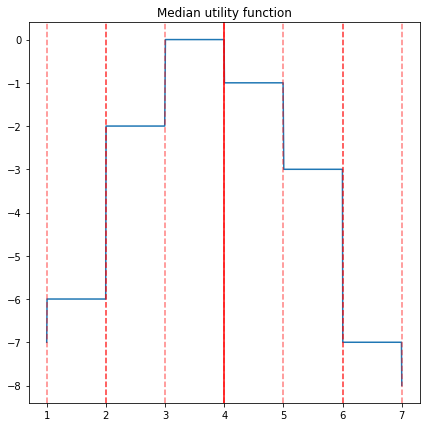

In [3]:
y = np.array([1,2,2,3,4,5,6,6, 7])
x = np.linspace(np.min(y), np.max(y),1000)
k = []
for r in x:
    k.append(median_utility(r,y))
plt.plot(x, k)
plt.axvline(y[median_index(y)-1], color = 'red')
for r in y:
    plt.axvline(r, color = 'r', linestyle ='--', alpha = 0.5)

plt.title('Median utility function')
print(y[median_index(y)-1])

## Simulación

Para la base de datos x, definamos los intervalos
$$I_i=(y_i, y_{i+1}),\ i\in\{1,\cdots, n-1\}$$

Notemos que cada uno de estos intervalos tiene distinta utilidad. Podemos reindexar a estos por el valor de la utilidad de los puntos en estos, es decir
$$I_k=\{I_i | d(r,x)=k, \forall r\in I_i\}$$

Siguiendo la idea de simular el mecanismo exponencial eligiendo un intervalo aleatoriamente y eligiendo uniformemente un valor sobre este intervalo. Denotamos por $K$ a la variable aleatoria que representa el elegir uno de los intervalos, de forma que:
$$Pr[Y = y | K = k] \sim Uniforme(I_k)$$
es decir
$$Pr[Y=y|K=k]=\mathbb{1}_{I_k}(y)\frac{1}{|I_k|}$$
de esta forma

$$Pr[Y=y]=\sum_{i}Pr[Y=y|K=i]Pr[K=i]$$
Como los intervalos son disjuntos $y$ se encuentra en un intervalo $I_{i'}$, entonces:
$$Pr[Y=y]=Pr[Y=y|K=i']Pr[K=i']$$
$$Pr[Y=y]=\mathbb{1}_{I_{i'}}(y)\frac{1}{|I_{i'}|}Pr[K=i']$$

notemos que si definimos $Pr[K=k]\propto |I_{k}|e^{-\frac{\varepsilon}{2}k}$

de esta forma 
$$Pr[Y=y]\propto e^{-\frac{\varepsilon}{2}i'}=e^{-\frac{\varepsilon}{2}u(y,x)}$$

In [4]:
def median_exponential_mechanism(x, epsilon, size):
    # Database 
    x = np.sort(x)
    # Unique values
    x_u = np.unique(x)
    # Intervals utility
    K = np.array([-median_utility(x_u[i-1]+(x_u[i]-x_u[i-1])/2, x) for i in range(1,x_u.size)])
    # Intervals Size
    S = np.array([np.abs(x_u[i-1]-x_u[i]) for i in range(1, x_u.size)])
    # Probability vector
    P = (S*np.exp((-epsilon/2)*K))/sum(S*np.exp((-epsilon/2)*K))
    #print(P)
    # Select an interval:
    i = [j for j in range(x_u.size-1)] #index
    I = np.random.choice(i, size, p = P)
    # Random value
    Y = np.zeros(I.size)
    for j in range(I.size):
        Y[j] = np.random.uniform(x_u[I[j]], x_u[I[j]+1])
    return Y

<AxesSubplot:ylabel='Density'>

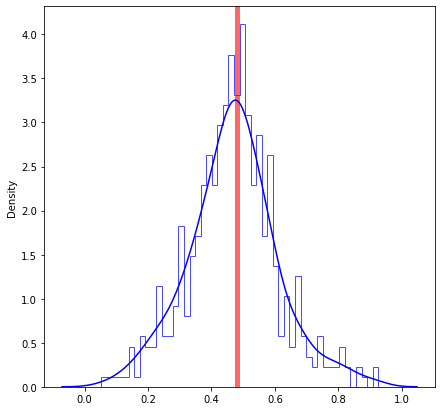

In [5]:
DATA = np.sort(np.random.rand(100))
result = median_exponential_mechanism(DATA, 0.1, 500)

plt.hist(result, bins = 50, histtype='step', density=True, color="blue", alpha=0.7)
plt.axvline(DATA[median_index(DATA)-1], color = 'red', linewidth = 5, alpha = 0.6)
sns.kdeplot(result, color="blue")

In [8]:
from ss_mechanisms import laplace_DP_noise_ss, cauchy_DP_noise_ss
import utils 

def median_ss(data, beta):
    m = utils.median_index(data)
    n = data.size
    data_ = np.concatenate([np.zeros(np.abs(m-n-1)), data, np.max(data)*np.ones(m+1)])
    m_ = utils.median_index(data)
    return np.max([np.exp(-k*beta)*np.max([(data_[m_+t]-data_[m+t-k-1]) for t in range(k+1)]) for k in range(n)])

0.07974889877531446


<AxesSubplot:ylabel='Density'>

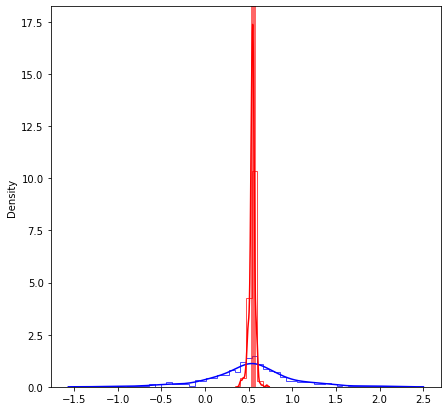

In [9]:
DATA = np.sort(np.random.rand(100))
result = laplace_DP_noise_ss(DATA, 0.5, 0.01, np.median, median_ss, 500)
result_ = median_exponential_mechanism(DATA, 0.5, 500)

plt.hist([result, result_], bins = 50, histtype='step', density=True, color=["blue", "red"], alpha=0.7)
plt.axvline(DATA[utils.median_index(DATA)], color = 'red', linewidth = 5, alpha = 0.6)
sns.kdeplot(result, color="blue")
sns.kdeplot(result_, color="red")

0.00013984162859410104


<AxesSubplot:ylabel='Density'>

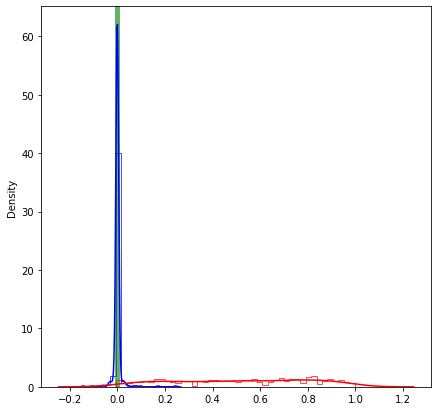

In [17]:
DATA = np.concatenate([np.zeros(70), np.ones(10)])
result = cauchy_DP_noise_ss(DATA, 0.5, np.median, median_ss, 500)
result_ = median_exponential_mechanism(DATA, 0.5, 500)

plt.hist([result, result_], bins = 50, histtype='step', density=True, color=["blue", "red"], alpha=0.7)
plt.axvline(DATA[utils.median_index(DATA)-1], color = 'green', linewidth = 5, alpha = 0.6)
sns.kdeplot(result, color="blue")
sns.kdeplot(result_, color="red")

0.25283959580474646


<AxesSubplot:ylabel='Density'>

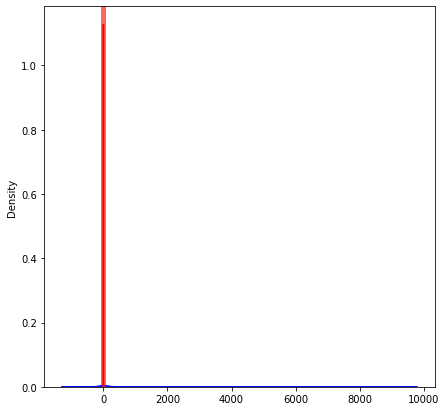

In [49]:
DATA = np.concatenate([np.zeros(10), np.ones(10)])
result = cauchy_DP_noise_ss(DATA, 0.5, np.median, median_ss, 500)
result_ = median_exponential_mechanism(DATA, 0.5, 500)

plt.hist([result, result_], bins = 50, histtype='step', density=True, color=["blue", "red"], alpha=0.7)
plt.axvline(DATA[utils.median_index(DATA)-1], color = 'red', linewidth = 5, alpha = 0.6)
sns.kdeplot(result, color="blue")
sns.kdeplot(result_, color="red")

In [39]:
EPSILON = np.linspace(1e-4, 1, 50)
ERROR_SS = []
ERROR_EXP = []
DATA = np.sort(np.random.rand(100))
for eps in EPSILON:
    result = laplace_DP_noise_ss(DATA, eps, 100**-1.1, np.median, median_ss, 500)
    result_ = median_exponential_mechanism(DATA, eps, 500)
    M = np.median(DATA)
    ERROR_SS.append(np.mean(np.abs(result-M)))
    ERROR_EXP.append(np.mean(np.abs(result_-M)))


0.9681172974697843
0.8135555047955036
0.6838819176939432
0.574877159077555
0.4832467995987889
0.4062215129527656
0.3626363770514733
0.32606515272956255
0.2931820703951658
0.26361518758334596
0.2370300715556599
0.2131260165119206
0.19301890779098171
0.18077160593132297
0.16930141137456137
0.15855901564711342
0.14849823896246114
0.1394489345627135
0.13106431504560376
0.12318383594854922
0.11577718491657481
0.10881587217989724
0.10227312096769223
0.09612376451093285
0.09045748724827772
0.08699947402525696
0.08367365389994809
0.08047497338818106
0.07739857219062432
0.07443977580770575
0.07276874616339647
0.07136428937841163
0.06998693899507433
0.06863617185238866
0.06731147488650964
0.06601234493586546
0.06473828855004071
0.06348882180234863
0.06226347010602035
0.06106176803394196
0.05988325914187071
0.058727495795063055
0.05759403899824893
0.056482458228887554
0.05539233127364141
0.05432324406800636
0.05327479053903687
0.052246572451106824
0.05123819925464699
0.0504001228379562


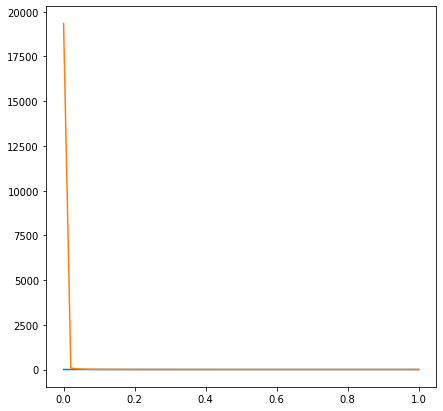

In [41]:
plt.plot(EPSILON, ERROR_EXP)
plt.plot(EPSILON, ERROR_SS)